In [3]:
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 86.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray-einstats 0.9.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
blosc2 3.5.1 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
bigframes 2.8.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 wh

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/tmp/ipython-input-3-3120809649.py:112: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states_tensor = torch.tensor(states, dtype=torch.float32)


Episode 0 | Reward: 11.0


Episode 10 | Reward: 24.0
Episode 20 | Reward: 14.0
Episode 30 | Reward: 19.0
Episode 40 | Reward: 33.0


Episode 50 | Reward: 13.0
Episode 60 | Reward: 10.0
Episode 70 | Reward: 18.0
Episode 80 | Reward: 16.0
Episode 90 | Reward: 16.0


Episode 100 | Reward: 26.0
Episode 110 | Reward: 18.0
Episode 120 | Reward: 25.0
Episode 130 | Reward: 40.0
Episode 140 | Reward: 10.0


Episode 150 | Reward: 104.0
Episode 160 | Reward: 22.0
Episode 170 | Reward: 24.0
Episode 180 | Reward: 42.0
Episode 190 | Reward: 25.0


Episode 200 | Reward: 18.0
Episode 210 | Reward: 16.0
Episode 220 | Reward: 15.0
Episode 230 | Reward: 42.0
Episode 240 | Reward: 34.0


Episode 250 | Reward: 27.0
Episode 260 | Reward: 22.0
Episode 270 | Reward: 34.0
Episode 280 | Reward: 15.0
Episode 290 | Reward: 24.0


Episode 300 | Reward: 32.0
Episode 310 | Reward: 34.0
Episode 320 | Reward: 87.0
Episode 330 | Reward: 48.0
Episode 340 | Reward: 16.0
Episode 350 | Reward: 72.0


Episode 360 | Reward: 30.0
Episode 370 | Reward: 24.0
Episode 380 | Reward: 40.0
Episode 390 | Reward: 19.0
Episode 400 | Reward: 23.0


Episode 410 | Reward: 43.0
Episode 420 | Reward: 39.0
Episode 430 | Reward: 24.0
Episode 440 | Reward: 144.0
Episode 450 | Reward: 17.0


Episode 460 | Reward: 51.0
Episode 470 | Reward: 59.0
Episode 480 | Reward: 35.0
Episode 490 | Reward: 57.0


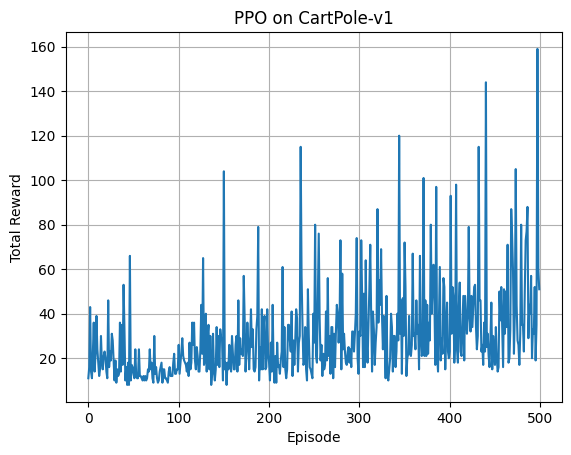

In [3]:
import os
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
import imageio

# --- Настройки ---
ENV_NAME = 'CartPole-v1'
GAMMA = 0.99
LAMBDA = 0.95
CLIP_EPS = 0.2
ENTROPY_COEF = 0.01
VF_COEF = 0.5
LR = 2.5e-4
EPOCHS = 4
BATCH_SIZE = 64
EPISODES = 500
VIDEO_INTERVAL = 50
SAVE_DIR = './ppo_videos'
os.makedirs(SAVE_DIR, exist_ok=True)

device = torch.device('cpu')

# --- Актор-Критик ---
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
        )
        self.policy_head = nn.Linear(64, act_dim)
        self.value_head = nn.Linear(64, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.policy_head(x), self.value_head(x).squeeze(-1)

    def get_dist_and_value(self, x):
        logits, value = self.forward(x)
        return Categorical(logits=logits), value

# --- GAE ---
def compute_gae(rewards, values, gamma=GAMMA, lam=LAMBDA):
    values = values + [0]
    advs = []
    gae = 0
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t+1] - values[t]
        gae = delta + gamma * lam * gae
        advs.insert(0, gae)
    return advs

# --- Видео ---
def record_video(env, model, episode):
    frames = []
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode="rgb_array")
        frames.append(frame)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        dist, _ = model.get_dist_and_value(state_tensor)
        action = dist.sample().item()
        state, _, done, _ = env.step(action)
    imageio.mimsave(os.path.join(SAVE_DIR, f"ppo_ep_{episode}.mp4"), frames, fps=30)

# --- Тренировка ---
def train():
    env = gym.make(ENV_NAME)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n

    model = ActorCritic(obs_dim, act_dim)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    reward_history = []

    for episode in range(EPISODES):
        states, actions, rewards, values, log_probs = [], [], [], [], []
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            dist, value = model.get_dist_and_value(state_tensor)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            next_state, reward, done, _ = env.step(action.item())

            states.append(state)
            actions.append(action.item())
            rewards.append(reward)
            values.append(value.item())
            log_probs.append(log_prob.item())

            total_reward += reward
            state = next_state

        advantages = compute_gae(rewards, values)
        returns = [a + v for a, v in zip(advantages, values)]

        # Тензоры
        states_tensor = torch.tensor(states, dtype=torch.float32)
        actions_tensor = torch.tensor(actions)
        old_log_probs_tensor = torch.tensor(log_probs)
        returns_tensor = torch.tensor(returns, dtype=torch.float32)
        advantages_tensor = torch.tensor(advantages, dtype=torch.float32)
        advantages_tensor = (advantages_tensor - advantages_tensor.mean()) / (advantages_tensor.std() + 1e-8)

        # PPO обновление
        for _ in range(EPOCHS):
            for i in range(0, len(states), BATCH_SIZE):
                sl = slice(i, i + BATCH_SIZE)
                dist, value = model.get_dist_and_value(states_tensor[sl])
                new_log_probs = dist.log_prob(actions_tensor[sl])
                entropy = dist.entropy().mean()

                ratio = torch.exp(new_log_probs - old_log_probs_tensor[sl])
                surr1 = ratio * advantages_tensor[sl]
                surr2 = torch.clamp(ratio, 1 - CLIP_EPS, 1 + CLIP_EPS) * advantages_tensor[sl]
                policy_loss = -torch.min(surr1, surr2).mean()
                value_loss = ((returns_tensor[sl] - value) ** 2).mean()
                loss = policy_loss + VF_COEF * value_loss - ENTROPY_COEF * entropy

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        reward_history.append(total_reward)
        if episode % 10 == 0:
            print(f"Episode {episode} | Reward: {total_reward}")

        if episode % VIDEO_INTERVAL == 0:
            record_video(env, model, episode)

    env.close()
    plt.plot(reward_history)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("PPO on " + ENV_NAME)
    plt.grid()
    plt.show()

if __name__ == "__main__":
    train()